In this project, we will use machine learning to complete a single word speech recognition task.  Here, we use one second recordings of the digits zero - nine from the Google Speech Command database https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html, meaning that every recording used belongs to one of ten classes (zero, one, two, three, four, five, six, seven, eight, or nine).  To perform the recognition, we have two frameworks as shown below:

1. We can directly feed the audio signal into a neural network for audio classification.  Models that read in the raw signal with no feature extraction are called end to end models.

2. We can extract some short time feature from each frame of the audio, giving the spectrogram or another acoustic representation.  We can then take these combination of these features accross time as an image and perform image classification on them.


In this project, you will explore both methods.

You may (but are not required) to change any of the code given here.  You can just add your new code to the bottom of the file.

**Before you run anything, go to the toolbar at the top and select: Runtime > Change runtime type > GPU.**

Mount your google drive to give google colab access to files stored in your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Change directory to the place where the google ai speech commands dataset is stored.  You can find the path by typing "!ls" to see what files and directories are currently available.  Then type "!ls <subdirectory you want to explore>" to see what files are in the next subdirectory.  Keep doing that, separating the subdirectories with slashes "/" until you get to the speech_commands_v0.01 folder as shown below.  Then put that filepath in the os.chdir command.

In [ ]:
import os

os.chdir('/content/gdrive/My Drive/speech_commands_v0.01')
!ls


_background_noise_  happy    README.md		     train_list.txt
bed		    house    right		     tree
bird		    left     seven		     two
cat		    LICENSE  sheila		     up
dog		    marvin   six		     validation_list.txt
down		    nine     stop		     wow
eight		    no	     testing_digit_list.txt  yes
five		    off      testing_list.txt	     zero
four		    on	     three
go		    one      train_digit_list.txt


Load in the text file that lists the audio files to be used.  We'll only use the subset of files listed in this text file for this project.

In [ ]:
text_file = open("train_digit_list.txt", "r")
training_list = text_file.read().splitlines()

Read in all of the audio files.  Store the raw audio to a list called all_wav_list.  Store any features extracted to a listt called all_feat_list.  This part may take a while depending on what features you extract.  You can go watch netflix or work on your homework or something and come back when it's done>  You have to redo this every time you run the code which can be kind of a pain.  If you prefer, you can store the list after you've generated it and then redownload it instead of recreating it:

# Import the pickle library

import pickle

# Create a list

l = [1,2,3,4] # create a list
#store the list as a file
    with open("test.txt", "wb") as fp:   #Pickling
        pickle.dump(l, fp)
# open the file and read the list from it 
    with open("test.txt", "rb") as fp:   # Unpickling
        b = pickle.load(fp)

In [ ]:
import librosa.feature as lf
import scipy.io.wavfile as wav
import numpy as np
from tqdm.notebook import tnrange

#initialize lists
all_wav_list = []
all_feat_list = []
all_labels = []

#loop through all audio files listed in the text file
for i in tnrange(len(training_list), desc='Load in files'):
  #load in the given audio file
  fs, audio = wav.read(training_list[i])

  
  z=np.zeros((fs,))
  #if an audio file is less than a second, add zeros to it to make it a second
  if audio.size<=fs:
    z[:audio.size]=audio
  # if an audio file is longer than a second, clip it to a second
  elif audio.size>fs:
    z=audio[:fs]
  feat = lf.melspectrogram(z.astype('float'), sr =fs)
  #here, we use the melspectrogram as a feature. You can use other features like
  #LPCs, mfccs, or whatever you find.  The Librosa library has more features,
  #and you can explore other libraries
  all_wav_list.append(z.astype('float'))
  all_feat_list.append(feat.reshape(1, feat.shape[0], feat.shape[1]))

# get labels from the file name (ie which word is in the audio file)
  which_word=training_list[i].split('/')[0]
  all_labels.append(which_word)



Let's listen to one of the audio files to verify that it loaded in correctly

In [ ]:
import IPython
IPython.display.Audio(training_list[0])

And verify that the sizes of the lists look correct

In [ ]:
print(len(all_wav_list))
print(len(all_feat_list))
print(len(all_labels))
print(all_feat_list[0].shape)

2494
2494
2494
(1, 128, 32)


Now we'll start with speech recognition from the raw audio.  We'll concatenate the raw signals into a matrix X_sig.

In [ ]:
X_sig = np.vstack(all_wav_list)
X_sig = X_sig.reshape(X_sig.shape[0], X_sig.shape[1], 1)
print(X_sig.shape)

(2494, 16000, 1)


And we'll one hot encode our labels.  This will transform our labels from words to a vector that represents the label with a numerical value.  All of the encoded labels will have the same norm to prevent bias.  For instance, if there were five words then they would be encoded as:

$y1 = [1, 0, 0, 0, 0]$

$y2 = [0, 1, 0, 0, 0]$

$y3 = [0, 0, 1, 0, 0]$

$y4 = [0, 0, 0, 1, 0]$

$y5 = [0, 0, 0, 0, 1]$

This will be useful in comparing correct and incorrect labels later

In [ ]:
from sklearn import preprocessing
import scipy as sp

le = preprocessing.LabelEncoder()
le.fit(all_labels)
encoded_labels = le.transform(all_labels)

oh_enc = preprocessing.OneHotEncoder()
oh_enc.fit(encoded_labels.reshape(-1,1))

y = oh_enc.transform(encoded_labels.reshape(-1,1))
y = sp.sparse.csr_matrix.toarray(y)

Then we'll devide the whole set into a testing and a training set.

In [ ]:
from sklearn.model_selection import train_test_split

X_sig_train, X_sig_test, y_train, y_test = train_test_split(X_sig, y, test_size=0.2, random_state=42)

Create and run an end to end model for audio classification:  We create a sequential model using the keras module in tensorflow and then add the desired layer to it.

The graph is created of a static size, so the size of every layer must be pre-defined.  Tensorflow will take care of calculated the sizes needed in each layer if we specify the size of the input layer, the size of the output layer, and the parameters of each desired layers.

The input is a collection of 1D signals each one second long.  The static graph requires that all inputs be the same size which we make sure of in shaping the input matrix above.  This will have the shape (number_of_signals, len_of_signals, 1).  The number of signals we feed into the network does not affect its structure, so we just need to specify the shapes of these inputs in input layer as (fs, 1) for the one second long signals.

This input is then passed into convolutional layers and then recurrent layers (GRU) before the fully connected network (ie multilayer perceptrion) makes the final output decision.  In betweek the layers are forms of regularization such as MaxPooling (downsampling the output of a layer), dropout(randomly setting some percentage of the weights of a layer to zero for given iteration), and batch normalization (normalizing the mean and standard deviation of the output of a layer so that the numbers don't become too large).  These methods try to ensure that the solution found by the neural network does not rely too strongly on any one trend that occurs in its weights or any trend that only occurs with a small numbe of its weights.  This helps ensure that the solution found by the network is not too specific to the training data and generalizes well to any other test set of a similar distribution.

At the output layer, we set the size of the last fully connected layer to 10 to let the network know that we expect a classification decision between one of the ten classes.  The output of the last layer is of the form:

$out=[x_0, x_1, x_2, x_3, x_4,x_5,x_6,x_7,x_8,x_9]$

where each $x_i$ is the calculated probability that the given audio sample belongs to class i.  The classification decision is then $y_{pred} =argmax_i(out)$ which we compare to the actual labels stored in the actual $y_{test}$.

In [ ]:
import tensorflow as tf

model_e2e = tf.keras.models.Sequential()
model_e2e.add(tf.keras.Input(shape=(fs,1))) #Make sure that the input size is the size of the signal
model_e2e.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True, )) #adjust input to unit variance and zero mean
#First Conv1D layer
model_e2e.add(tf.keras.layers.Conv1D(8,13, padding='valid', activation='relu', strides=1)) #Convolve with 8 1D kernels of length 13
model_e2e.add(tf.keras.layers.MaxPooling1D(3)) #Downsample - take the max out of every three elements
model_e2e.add(tf.keras.layers.Dropout(0.3)) #drop nodes with probability 0.3
#Second Conv1D layer
model_e2e.add(tf.keras.layers.Conv1D(16, 11, padding='valid', activation='relu', strides=1)) #Convolve with 16 1D kernels of length 11
model_e2e.add(tf.keras.layers.MaxPooling1D(3))
model_e2e.add(tf.keras.layers.Dropout(0.3))
#Third Conv1D layer
model_e2e.add(tf.keras.layers.Conv1D(32, 9, padding='valid', activation='relu', strides=1))
model_e2e.add(tf.keras.layers.MaxPooling1D(3))
model_e2e.add(tf.keras.layers.Dropout(0.3))
model_e2e.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True))
model_e2e.add(tf.keras.layers.Bidirectional(tf.python.keras.layers.CuDNNGRU(128, return_sequences=True), merge_mode='sum')) #Recurrent layer, uses time series data
model_e2e.add(tf.keras.layers.Bidirectional(tf.python.keras.layers.CuDNNGRU(128, return_sequences=True), merge_mode='sum'))
model_e2e.add(tf.keras.layers.Bidirectional(tf.python.keras.layers.CuDNNGRU(128, return_sequences=False), merge_mode='sum')) #set return sequences to False for last recurrent layer
model_e2e.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True))
#Flatten layer
model_e2e.add(tf.keras.layers.Flatten()) # Turn 2D result of convolution to a single vector
#Dense Layer 1
model_e2e.add(tf.keras.layers.Dense(256, activation='relu')) #Fully connected layer
model_e2e.add(tf.keras.layers. Dense(10, activation="softmax")) #output layer, need size = num_classes
model_e2e.summary() #show breakdown of parameters

model_e2e.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy']) #decide loss function and metrics

hist = model_e2e.fit(
    x=X_sig_train, 
    y=y_train,
    epochs=50, 
    batch_size=32)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 16000, 1)          4         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15988, 8)          112       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5329, 8)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5329, 8)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5319, 16)          1424      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1773, 16)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1773, 16)         

In [ ]:
model_e2e.evaluate(X_sig_test, y_test)

16/16 [==============================] - 4s 275ms/step - loss: 0.4062 - accuracy: 0.8998


[0.40616175532341003, 0.8997995853424072]

Now we'll move on to performing speech recognition by identifying the image of the spectrogram.  We'll begon by concatenating the features extracted into a matrix

In [ ]:
X_im = np.vstack(all_feat_list)
X_im=np.array(X_im.reshape(X_im.shape[0],X_im.shape[1],X_im.shape[2], 1))
print(X_im.shape) 

(2494, 128, 32, 1)


Let's view an image of our features

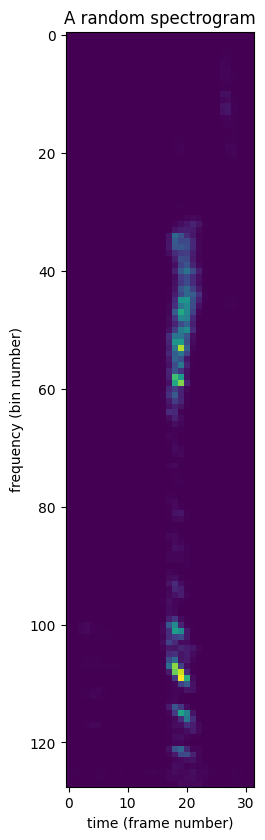

In [ ]:
import matplotlib.pyplot as plt
im = X_im[100,:,:].reshape(X_im.shape[1],X_im.shape[2])
im=im[::-1,:]
plt.figure(figsize=(20,10), dpi=100)
plt.imshow(im)
plt.ylabel('frequency (bin number)')
plt.xlabel('time (frame number)')
plt.title('A random spectrogram');


We'll similarly split our whole set into testing and training sets

In [ ]:
from sklearn.model_selection import train_test_split

X_im_train, X_im_test, y_train, y_test = train_test_split(X_im, y, test_size=0.2, random_state=42)

Here we similarly train a CNN to recognize the images generated from the speech signals.  We again create the sequential model, and specify the input size in the first layer.

The imput matrix contains a collection of 2D signals.  Here the input matrix is of the shape (number_of_images, number_of_features (or height of each image), number_of_frames (or width of each image), 1).  If these were color RGB images, then we would need to replace the 1 with a 3 to let the network know that the signals have a depth of 3.  We will stick with grayscale images for simplicity.  We tell the network to expect some number of images with a shape of (num_features, num_timesteps, 1) as the input here.

This input is then passed into multiple 2D convolutional layers with maxpooling as regularization between.  This 2D maxpooling downsamples accross both the x and y dimensions of the image.

The output of the last conv layer is then flattened into a 1D vector and passed to the multilayer perceptiron for a final classification decision in the same way as in the end to end model.

In [ ]:

import tensorflow as tf

n_features = X_im.shape[1]
time_steps = X_im.shape[2]

model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(n_features, time_steps, 1))) # convolve with 32 kernels of size 3 x 3
model_cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')) # convolve with 32 kernels of size 3 x 3
model_cnn.add(tf.keras.layers.MaxPooling2D((2, 2))) #Dowmsample by 2 in each direction- take max element of every 2
model_cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')) # convolve with 64 kernels of size 3 x 3
model_cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')) # convolve with 128 kernels of size 3 x 3
model_cnn.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_cnn.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_cnn.add(tf.keras.layers.Flatten()) # Flatten output into a vector
model_cnn.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')) # Fully connected layer with 128 nodes
model_cnn.add(tf.keras.layers.Dense(10, activation='softmax')) #output layer, size must equal the number of classes

Adam=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=False)

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam,
              metrics=['accuracy'])
model_cnn.summary() #print out breakdown of model parameters
history=model_cnn.fit(X_im_train, y_train, validation_split = 0.2, batch_size=200, epochs=500)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 128, 32, 32)       320       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 128, 32, 32)       9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 64, 16, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 16, 64)        18496     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 64, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 32, 8, 64)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 8, 128)      

In [ ]:
model_cnn.evaluate(X_im_test, y_test)

16/16 [==============================] - 0s 13ms/step - loss: 42245080.0000 - accuracy: 0.2585


[42245080.0, 0.2585170269012451]

Now that we've run this experiment on clean, noise-free signals taken with high quality microphones, and recorded by speakers all with similar speaking styles and accents, let's explore a less ideal case.  In real life, you can rarely expect the input speech to be of such high quality and need to prepare to handle common degradations in the signals.  There could be additive, noise in the background, there could be multiple speakers talking over each other, a speaker could have an accent not present in the training data, etc..  We need to be creative in how we deal with these challenges.  Here we'll introduce another common problem in audio processing: Reverberation.  Reverberations, or echos, occur when not only the original signal reaches the recording device, but also reflections of the soundwave off of nearby surfaces are directed at the microphone and also appear in the signal.  This can be modeled as multiple delayed and attenuated versions of the original signal being added back into the original signal through convolution with a room impulse function.  For this reason, we often refer to reverberations as convolutional noise, as opposed to addative noise which is added on top of the signal

Install the pyroomacoustics library.  It is a helpful python library that deals with calculating the effects of echos in a given

In [ ]:
!pip install pyroomacoustics

     |████████████████████████████████| 1.1MB 7.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/89/e3/d576f6f02bc75bacbc3d42494e8f1d063c95617d86648dba243c2cb3963e/pybind11-2.5.0-py2.py3-none-any.whl
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.4.2-cp36-cp36m-linux_x86_64.whl size=9520155 sha256=0468fbc90a3c3136d91b5f11c41d291226ed7367cf6c48963b8ff9fb79223564
  Stored in directory: /root/.cache/pip/wheels/a8/36/c1/e2c6c0c9a018975e20f7c4694ee1d19f768ac7b3aba168231a
Successfully built pyroomacoustics


Read in a new test set from another text file

In [ ]:
text_file = open("testing_digit_list.txt", "r")
testing_list = text_file.read().splitlines()

Add reverberations to the test signals using the pyroom acoustic library

In [ ]:
from tqdm.notebook import tnrange
import pyroomacoustics as pra
import scipy.io.wavfile as wav
import numpy as np
import librosa.feature as lf

all_reverb_signals =[]
all_reverb_feat=[]
trial_labels = []

# The desired reverberation time and dimensions of the room
rt60 = 1.0  # seconds
room_dim = [20, 30, 10]  # meters

e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

# Create the room
for i in tnrange(len(testing_list)):

  fs, audio = wav.read(testing_list[i])
  room = pra.ShoeBox(
      room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
  )

  # place the source in the room
  room.add_source([2.5, 3.73, 1.76], signal=audio, delay=1.3)

  mic_locs = np.c_[
      [10, 1, 1], 
  ]

  # finally place the array in the room
  room.add_microphone_array(mic_locs)

  # Run the simulation (this will also build the RIR automatically)
  room.simulate()

  mics_signals = room.mic_array.signals
  mics_signals = mics_signals.reshape(mics_signals.size,)
  z=mics_signals[int(1.5*fs):int(2.5*fs)]

  feat = lf.melspectrogram(z.astype('float'), sr =fs)
  all_reverb_signals.append(z.astype('float'))
  all_reverb_feat.append(feat.reshape(1, feat.shape[0], feat.shape[1]))

  # get labels from the file name (ie which word is in the audio file)
  which_word=testing_list[i].split('/')[0]
  trial_labels.append(which_word)
  


/usr/local/lib/python3.6/dist-packages/pyroomacoustics/room.py:905: UserWarning: The number of rays used for ray tracing is larger than100000 which may result in slow simulation.  The numberof rays was automatically chosen to provide accurateroom impulse response based on the room volume and thereceiver radius around the microphones.  The number ofrays may be reduced by increasing the size of thereceiver.  This tends to happen especially for largerooms with small receivers.  The receiver is a spherearound the microphone and its radius (in meters) may bespecified by providing the `receiver_radius` keywordargument to the `set_ray_tracing` method.
  "The number of rays used for ray tracing is larger than"


Encode the labels from the new dataset using the same encoding scheme used previously.

In [ ]:

le.fit(trial_labels)

encoded_labels = le.transform(trial_labels)

oh_enc = preprocessing.OneHotEncoder()
oh_enc.fit(encoded_labels.reshape(-1,1))

y_trial = oh_enc.transform(encoded_labels.reshape(-1,1))
y_trial = sp.sparse.csr_matrix.toarray(y_trial)

In [ ]:
print(len(all_reverb_signals),len(all_reverb_feat))

2552 2552


Listen to an audio signal with reverb

In [ ]:
IPython.display.Audio(all_reverb_signals[0], rate=fs)

Confirm the size of the test signals

In [ ]:
X_sig_rev=np.vstack(all_reverb_signals)
X_sig_rev=X_sig_rev.reshape(X_sig_rev.shape[0],X_sig_rev.shape[1],1)
print(X_sig_rev.shape)

(2552, 16000, 1)


In [ ]:
X_im_rev = np.vstack(all_reverb_feat)
X_im_rev=X_im_rev.reshape(X_im_rev.shape[0],X_im_rev.shape[1],X_im_rev.shape[2], 1)
print(all_reverb_feat[0].shape)
print(X_im_rev.shape)

(1, 128, 32)
(2552, 128, 32, 1)


View an image with reverb

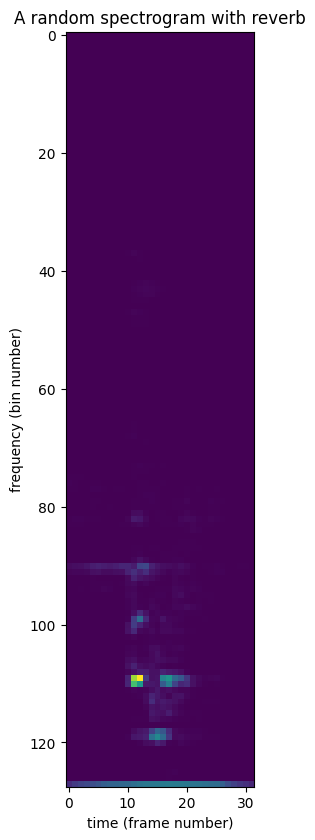

In [ ]:
im = X_im_rev[1,:,:].reshape(X_im_rev.shape[1],X_im_rev.shape[2])
im=im[::-1,:]
plt.figure(figsize=(20,10), dpi=100)
plt.imshow(im)
plt.ylabel('frequency (bin number)')
plt.xlabel('time (frame number)')
plt.title('A random spectrogram with reverb');

Now evaluate the performance of the models on the test sets with reverb.

In [ ]:
model_e2e.evaluate(X_sig_rev, y_trial)

80/80 [==============================] - 8s 101ms/step - loss: 1.9069 - accuracy: 0.5110


[1.9069026708602905, 0.5109717845916748]

In [ ]:
model_cnn.evaluate(X_im_rev, y_trial)

80/80 [==============================] - 1s 7ms/step - loss: 2942623.7500 - accuracy: 0.1983


[2942623.75, 0.1982758641242981]

We notice that the performance has worsened drastically with this degradation added to the signal  Your job in this project is to apply preprocessing to the reverberated signals as to give better performance in the networks.  Without changing the overall structure of the networks, process the reverberated signals to be more inteligible to a machine.  Think about what trends a machine will learn from the data and bring out those trends in the new test set.  Perform this for both networks.  For the end to end network, you should directly enhance the audio signals.  For the CNN, you can process the raw audio and then make your choice of feature (spectrogram, mfccs, lpcs, etc.) from the librosa library or any other library.  You can also concatenate features.  For this network, you may change the size of the input layer and retrain if your new features are of a different size than the original.  You can then apply image processing to the resulting images to the resulting image to enchance its ability to be classified correctly.  For each network, try at least 5 different processing techniques on the input signal.  Also try some combinations of those techniques and see if the combination of techniques is better or worse then the application of those techniques alone.  Submit all code at the bottom of this notebook.

Note that you may not:
1. Use additional audio files in training
2. Introduce any overlap between the files used for training and those used for testing
3. Add layers to any network (removing layers is fine)
4. Assume any knowledge about the room impulse generated or add the same reverb to any training data.

You should apply your knowledge of signal processing to enhance the reverberated signals for use by the neural network.